In [1]:
import pandas as pd
import numpy as np
import os
import json

In [2]:
df_combined = pd.read_csv("df_combined.csv")

/var/folders/4r/c8tzr0hs5hnfk639z0qnwlvr0000gn/T/ipykernel_60535/3902606256.py:1: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_combined = pd.read_csv("df_combined.csv")


In [3]:
df_combined.head()

,AGE,SEX,PATHOLOGY,INITIAL_EVIDENCE,swollen_nodes,std,sweating,diarrhea,pain,pain_char,...,ca_blockers,vag_discharge,wheezing_inhale,fatigue,menarche_12,breastfed_9,confusion,contact,ebolacase,bruising
0,21,M,HIV (initial infection),sweating,0,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,8,M,Allergic sinusitis,itchy_nose,0,0,0,0,1,heavy,...,0,0,0,0,0,0,0,0,0,0
2,49,F,Anaphylaxis,lost_consciousness,0,0,0,0,0,NaN,...,0,0,0,0,0,0,0,0,0,0
3,69,M,Tuberculosis,cough,0,0,0,0,1,heavy,...,0,0,0,0,0,0,0,0,0,0
4,30,F,Tuberculosis,cough_blood,0,0,0,0,1,sharp,...,0,0,0,0,0,0,0,0,0,0


In [4]:
## one hot encoding

columns = list(df_combined.columns)

numerical = []
categorical = []

for col in columns:

    if df_combined[col].dtype == 'int64':
        numerical.append(col)

    elif df_combined[col].dtype == 'object':
        categorical.append(col)

categorical.remove('PATHOLOGY')
categorical.remove('pain_somewhere')
categorical.remove('lesion_location')

In [5]:
#Hot encoding
df_combined = pd.get_dummies(df_combined, 
                         columns=categorical, 
                         dtype=int)

In [6]:
df_combined = df_combined[df_combined["PATHOLOGY"] != 'Ebola']

In [7]:
## pain_somewhere, lesion_location and swelling_location -> Y or N to simplify

df_combined['lesion_location'] = (df_combined['lesion_location'] != 'nowhere').astype(int)
df_combined['pain_somewhere'] = (df_combined['pain_somewhere'] != 'nowhere').astype(int)

# Random Forest

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

#feature columns
X = df_combined.drop(columns = ['PATHOLOGY'])

#target, what we want to predict
y = df_combined['PATHOLOGY']


#80% train, 20% temporary (will be 10% test, 10% validation)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.20, random_state=52, stratify=y)

#Split the temporary to 10% test, 10% validation
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=52, stratify=y_temp)

print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (202550, 162), (202550,)
Validation set: (25319, 162), (25319,)
Test set: (25319, 162), (25319,)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Maximum depth of each tree
   # 'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=52)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the model on the training set
grid_search.fit(X_train, y_train)

# Get the best parameters from the Grid Search
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Evaluate the best model on the validation set
#best_rf = grid_search.best_estimator_
#y_val_pred = best_rf.predict(X_val)
#val_accuracy = accuracy_score(y_val, y_val_pred)
#val_f1 = f1_score(y_val, y_val_pred)
#print(f"Validation Accuracy: {val_accuracy}")
#print("Validation Classification Report:")
#print(classification_report(y_val, y_val_pred))

# Finally, evaluate the model on the test set
y_test_pred = best_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: 

In [16]:
# Hyper parameters
max_depths = [None,10,20,30]
n_trees = [50, 100,200,300]
#min_samples_split = [2, 4, 6],  # Minimum number of samples required to split an internal node
min_samples_leaf = [1, 2, 4]

In [17]:
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time

ti = time.time()

grid_cv = GridSearchCV(RandomForestClassifier(), # first put the model object here
                          param_grid = {'max_depth':max_depths, # place the grid values for max_depth and
                                        'n_estimators':n_trees}, # and n_estimators here
                          scoring = 'neg_log_loss', # put the metric we are trying to optimize here as a string
                          cv = 5,
                          n_jobs=-1,
                          verbose=2) 

grid_cv.fit(X_train, y_train)

tf= time.time()
print("the total time of gridsearchcv is: ", tf-ti)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/philipbarron/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/philipbarron/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/philipbarron/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/philipbarron/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/Users/philipbarron/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2916: UserWarning: The y_pred values do not sum to

[CV] END ....................max_depth=None, n_estimators=50; total time= 1.4min
[CV] END ...................max_depth=None, n_estimators=100; total time= 2.7min
[CV] END ...................max_depth=None, n_estimators=200; total time= 4.5min
[CV] END ...................max_depth=None, n_estimators=200; total time= 5.1min
[CV] END ...................max_depth=None, n_estimators=300; total time= 6.4min
[CV] END .....................max_depth=10, n_estimators=200; total time= 1.0min
[CV] END .....................max_depth=10, n_estimators=300; total time= 1.5min
[CV] END .....................max_depth=10, n_estimators=300; total time= 1.5min
[CV] END .....................max_depth=20, n_estimators=100; total time=  58.7s
[CV] END .....................max_depth=20, n_estimators=200; total time= 2.1min
[CV] END .....................max_depth=20, n_estimators=300; total time= 3.0min
[CV] END .....................max_depth=20, n_estimators=300; total time= 3.1min
[CV] END ...................

In [18]:
grid_cv.best_params_

{'max_depth': None, 'n_estimators': 300}

In [24]:
emg_clf = grid_cv.best_estimator_
y_pred=emg_clf.predict(X_test)
y_pred_proba = emg_clf.predict_proba(X_test)
print(accuracy_score(y_test, y_pred))

0.598720328606975


In [37]:
#For validation set
emg_clf = grid_cv.best_estimator_
y_pred_v=emg_clf.predict(X_val)
y_pred_v_proba = emg_clf.predict_proba(X_val)
print(accuracy_score(y_val, y_pred_v))

0.5943757652355939


## Confusion Matrix

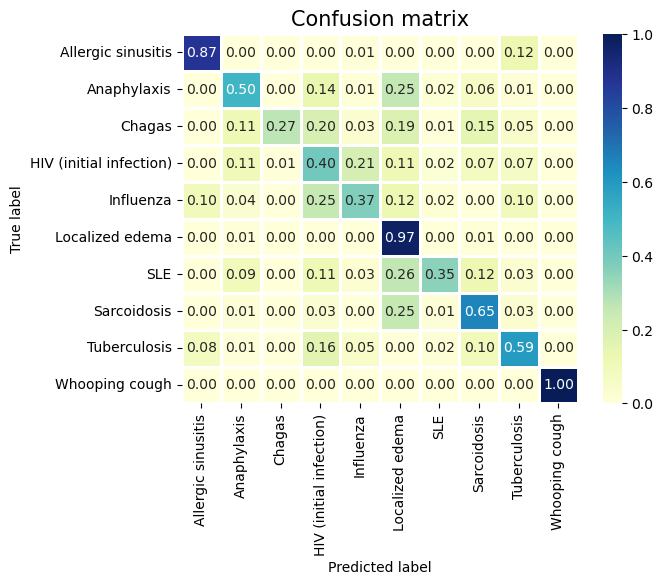

In [33]:
# %% Confusion matrix test set
import matplotlib.pyplot as plt
import seaborn as sns
confusionmatrix = confusion_matrix(y_test, y_pred, normalize = 'true')

sns.heatmap(confusionmatrix, annot=True, xticklabels = emg_clf.classes_, yticklabels=emg_clf.classes_, fmt=".2f", linewidths = 2, cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [34]:
importance_df = pd.DataFrame({'feature':X_train.columns,
                                'importance_score':grid_cv.best_estimator_.feature_importances_})

importance_df= importance_df.sort_values('importance_score',ascending=False)

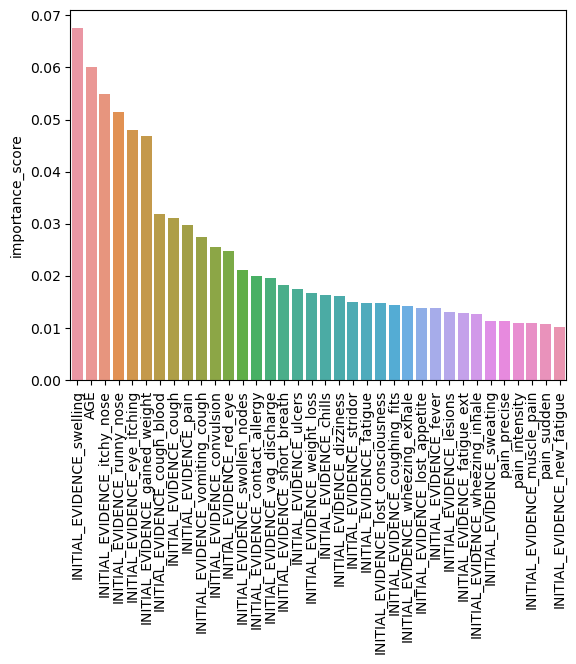

In [35]:
top_importance = importance_df.loc[importance_df['importance_score']>=0.01]
b = sns.barplot(top_importance, x = X_test.columns[top_importance.index], y = top_importance['importance_score'])
b.tick_params(axis='x',rotation=90)

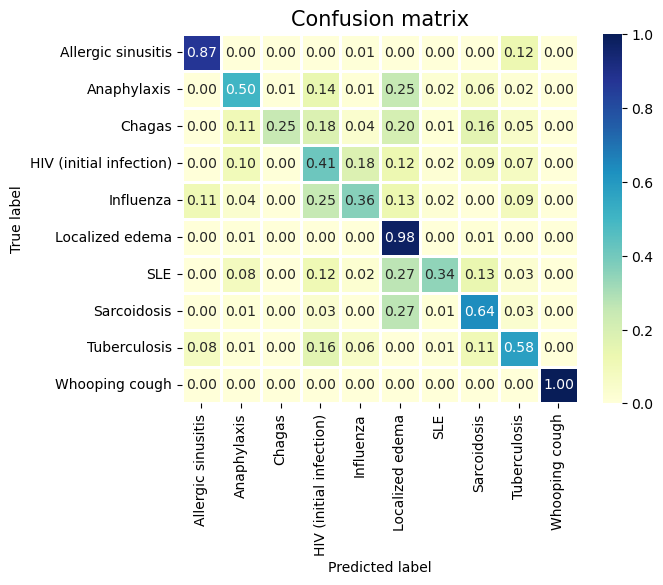

In [38]:
# %% Confusion matrix validation set
import matplotlib.pyplot as plt
import seaborn as sns
confusionmatrix = confusion_matrix(y_val, y_pred_v, normalize = 'true')

sns.heatmap(confusionmatrix, annot=True, xticklabels = emg_clf.classes_, yticklabels=emg_clf.classes_, fmt=".2f", linewidths = 2, cmap = 'YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()